# **Import the dataset**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# function that: imports the dataset and creates the features needed
def import_dataset(filepath, one_hot):

  # import the dataset
  df = pd.read_csv(filepath)
  df['date'] = pd.to_datetime(df['date'])

  # create the NMS feature
  df['NSM'] = df['date'].dt.hour * 3600 + df['date'].dt.minute * 60 + df['date'].dt.second  # seconds from midnight


  if (one_hot == True):

    # create the weekend/weekday features
    df['WeekStatusWeekend'] = df['date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
    df['WeekStatusWeekday'] = df['date'].dt.dayofweek.apply(lambda x: 1 if x < 5 else 0)

    # create the days features
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for i, day in enumerate(days):
        df[f'Day_of_week{day}'] = df['date'].dt.dayofweek.apply(lambda x: 1 if x == i else 0)
  else:

    # create the weekend/weekday features (0-6: Monday/Tuesday/...)
    df['week_status'] = df['date'].dt.dayofweek.apply(lambda x: 0 if x >= 5 else 1)

    # create the days features (0: weekend, 1: weekday)
    df['day_of_week'] = df['date'].dt.dayofweek

  df.drop('date', axis=1, inplace=True)
  return df

In [ ]:
# function that: prints the histogram of "Appliances"
def print_histogram(df):

  # Plot the histogram
  plt.figure(figsize=(8, 6))
  plt.hist(df, bins=60, color='skyblue', edgecolor='black')
  plt.title("Histogram of Appliances", fontsize=16)
  plt.xlabel("Appliances (Energy Usage)", fontsize=14)
  plt.ylabel("Frequency", fontsize=14)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.show()

In [ ]:
# function that: prints the boxplot of "Appliances"
def print_boxplot(df):

  # Plot the boxplot
  plt.figure(figsize=(8, 6))
  plt.boxplot(df, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'))
  plt.title("Boxplot of Appliances", fontsize=16)
  plt.xlabel("Appliances (Energy Usage)", fontsize=14)
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  plt.show()

In [ ]:
df = import_dataset('/content/drive/MyDrive/ML-FinalProject/energydata_complete.csv', one_hot = False)
df.shape
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,week_status,day_of_week
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,1,0
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,1,0
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,1,0
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,63000,1,0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,1,0


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

def split_data(df, test_size=0.25, random_state=42):
    # Splitting the dataset
    train, test = train_test_split(df, test_size=test_size, random_state=random_state)
    return train, test

train_data, test_data = split_data(df)

<Axes: >

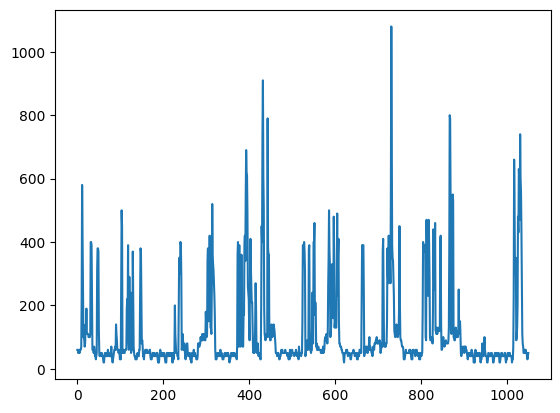

In [ ]:
# plot target for the 1st week
df['Appliances'][0:1051].plot()

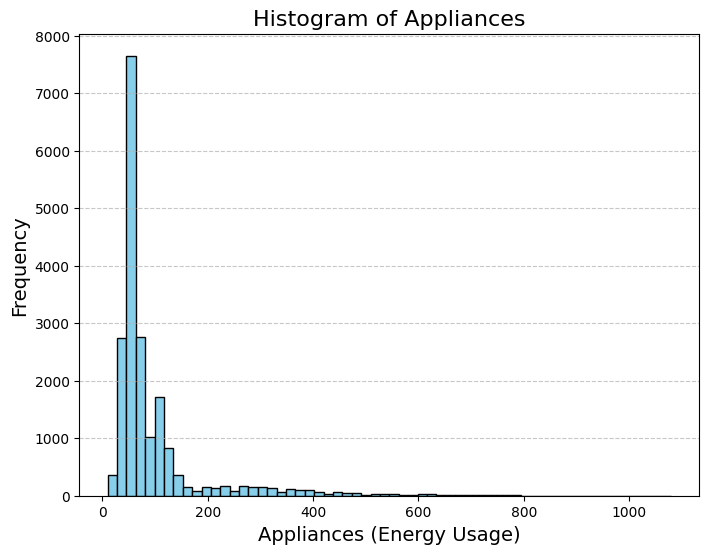

In [ ]:
print_histogram(df['Appliances'])

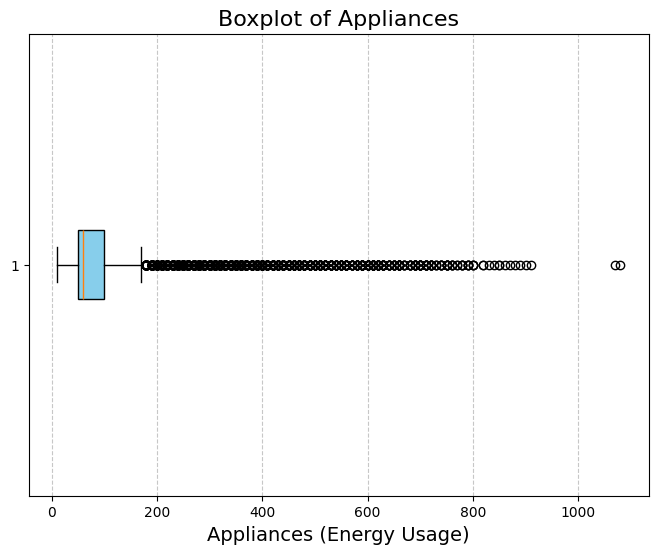

In [ ]:
print_boxplot(df['Appliances'])

# **Apply Correlation Matrix**

In [ ]:
def print_correlation_matrix(df, columns=None):

  # so initial df is the same
  df_copy = df.copy()

  # create the correlation matrix
  if columns is None:
      columns = df.select_dtypes(include='number').columns
  correlation_matrix = df_copy[columns].corr()

  # print the correlation matrix
  plt.figure(figsize=(12,8))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink":.8})
  plt.title("Correlation Matrix of Synthetic Dataset")
  plt.show()
  return

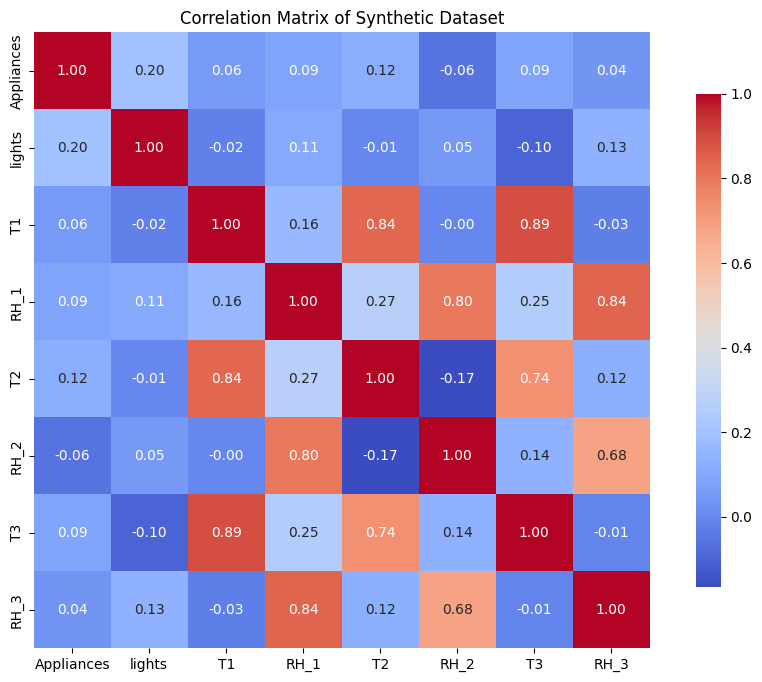

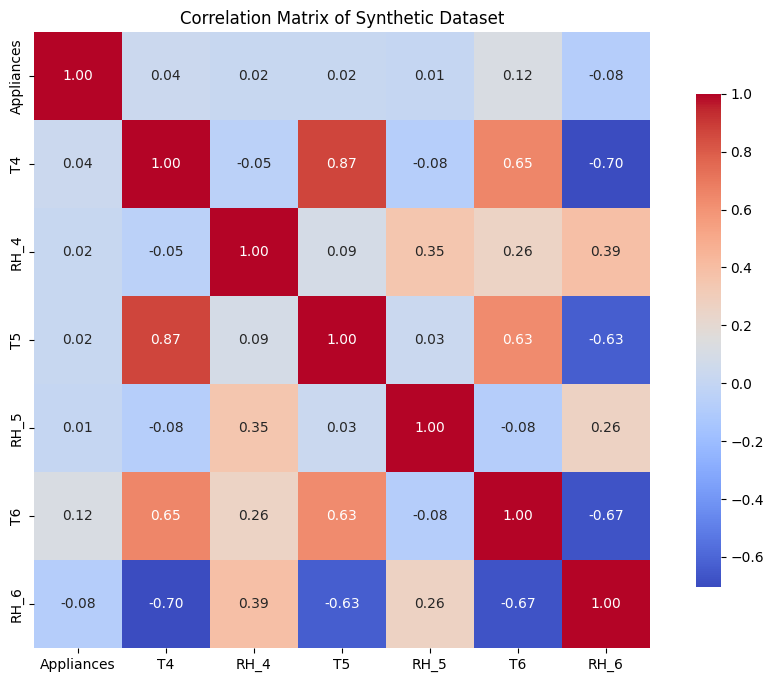

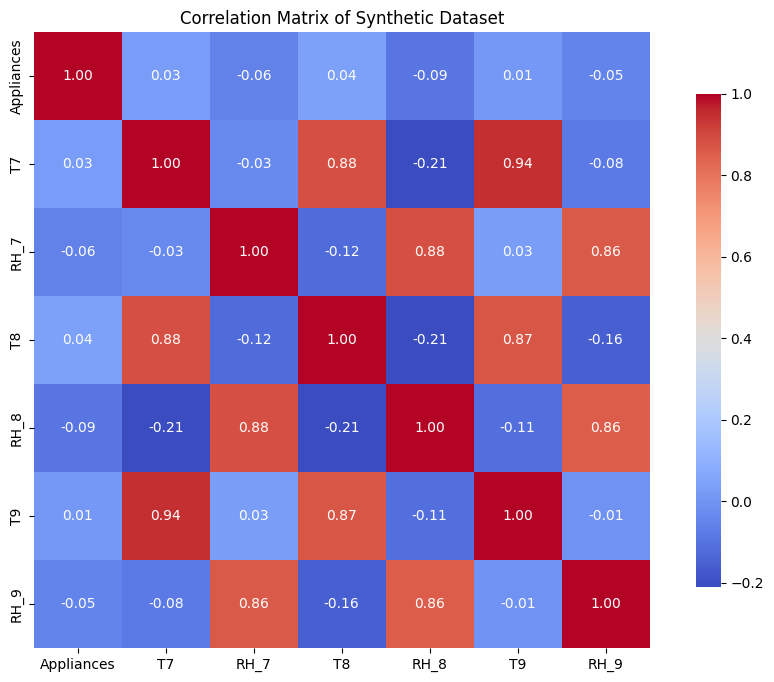

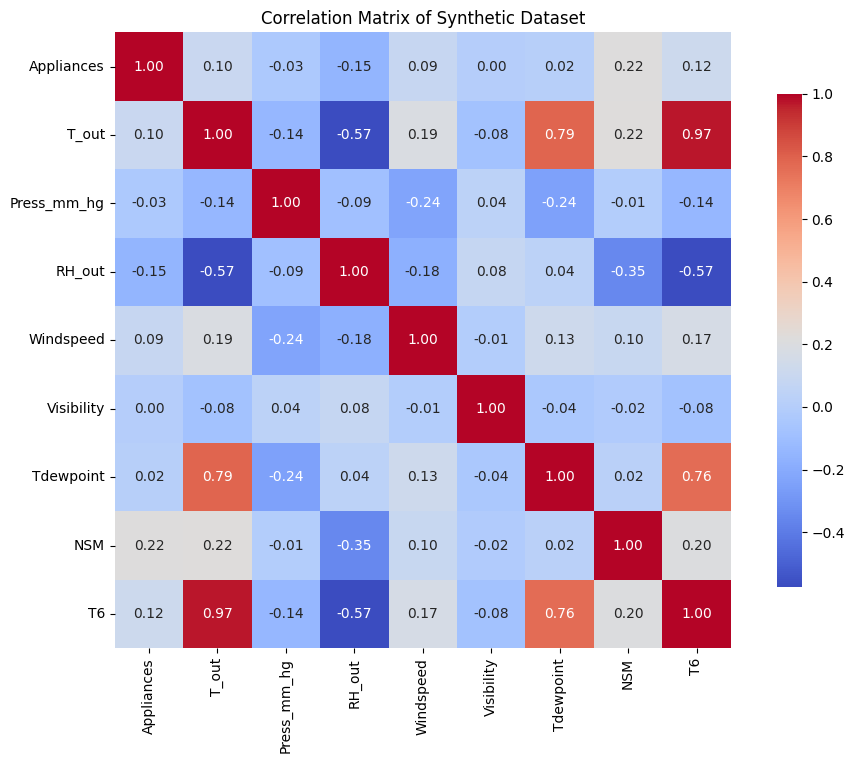

In [ ]:
# we create the correlation matrices of the paper
print_correlation_matrix(df, columns=["Appliances", "lights", "T1", "RH_1", "T2", "RH_2", "T3", "RH_3"])
print_correlation_matrix(df, columns=["Appliances", "T4", "RH_4", "T5", "RH_5", "T6", "RH_6"])
print_correlation_matrix(df, columns=["Appliances", "T7", "RH_7", "T8", "RH_8", "T9", "RH_9"])
print_correlation_matrix(df, columns=["Appliances", "T_out","Press_mm_hg","RH_out","Windspeed","Visibility","Tdewpoint","NSM","T6"])

# **Feature Importance - Boruta**

In [ ]:
pip install boruta

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
from boruta import BorutaPy

In [ ]:
def fast_boruta(train_data, target_column, n_iterations=30, random_state=42):

    # Separate features and target
    X = train_data.drop(columns=[target_column])
    y = train_data[target_column]

    # Store importances from each iteration
    all_importances = []
    np.random.seed(random_state)

    for i in range(n_iterations):
        print(f"Running iteration {i + 1}/{n_iterations}...")

        # Use a faster estimator with optimized parameters
        rf = ExtraTreesRegressor(n_estimators=50, max_depth=10, random_state=random_state + i)

        # Initialize Boruta with fewer iterations
        boruta_selector = BorutaPy(rf, n_estimators='auto', max_iter=50, random_state=random_state + i)

        # Fit Boruta
        boruta_selector.fit(X.values, y.values)

        # Calculate feature importances using fitted estimator
        rf.fit(X.values, y.values)
        feature_importances = pd.DataFrame({
            'Feature': X.columns,
            'Importance': rf.feature_importances_,
            'Iteration': i + 1
        })

        all_importances.append(feature_importances)

    # Combine all importance DataFrames
    combined_importances = pd.concat(all_importances, axis=0)
    return combined_importances

In [ ]:
def plot_boruta_boxplots(combined_importances):

    # Calculate median importance for sorting
    median_importances = combined_importances.groupby('Feature')['Importance'].mean().sort_values(ascending=False)
    sorted_features = median_importances.index

    # Sort the DataFrame by the calculated order
    combined_importances['Feature'] = pd.Categorical(
        combined_importances['Feature'],
        categories=sorted_features,
        ordered=True
    )
    combined_importances = combined_importances.sort_values('Feature')

    # Create a boxplot for feature importances
    plt.figure(figsize=(16, 8))
    sns.boxplot(
        data=combined_importances,
        x="Feature",
        y="Importance",
        palette="coolwarm"
    )
    plt.xticks(rotation=90)
    plt.title("Feature Importance Boxplots Across Boruta Runs")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

Running iteration 1/10...
Running iteration 2/10...
Running iteration 3/10...
Running iteration 4/10...
Running iteration 5/10...
Running iteration 6/10...
Running iteration 7/10...
Running iteration 8/10...
Running iteration 9/10...
Running iteration 10/10...


<ipython-input-39-7c53c9169102>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


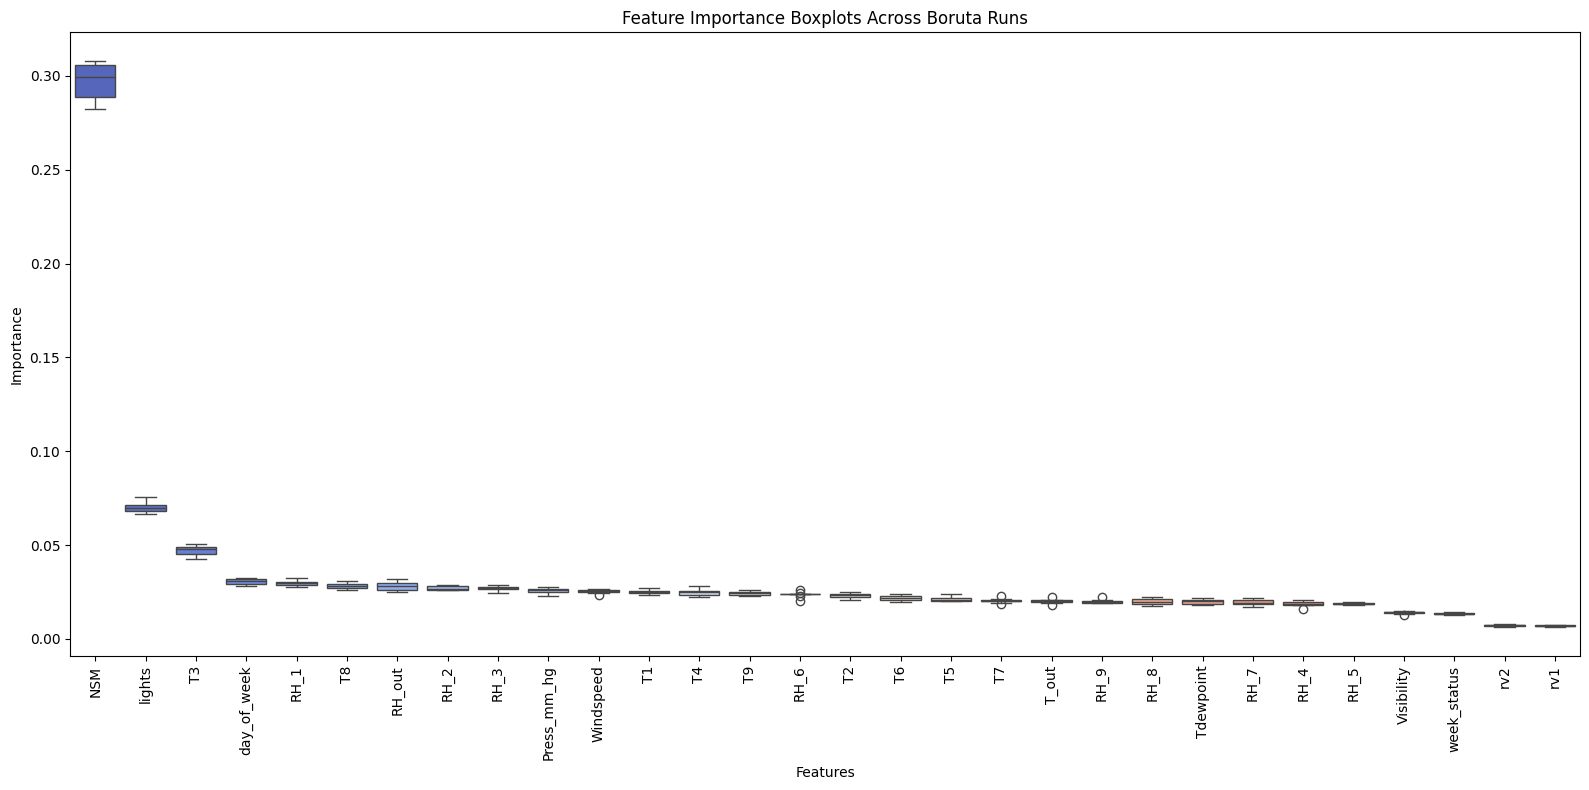

In [ ]:
# Example Usage
target_column = 'Appliances'

# Run Boruta 30 times
n_iterations = 10
combined_importances = fast_boruta(train_data, target_column, n_iterations=n_iterations)

# Plot the boxplots
plot_boruta_boxplots(combined_importances)

# **Recursive Feature Elimination**

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# function that: ranks the importance  of the features
def perform_rfe(train_data, target_column):

    # Separate features and target
    X = train_data.drop(columns=[target_column])
    y = train_data[target_column]

    # Initialize Random Forest Regressor
    rf = ExtraTreesRegressor(n_estimators=50, max_depth=10, random_state=42)

    # RFE object with Random Forest as the estimator
    rfe = RFE(estimator=rf, n_features_to_select=1, step=1)

    # Fit RFE
    rfe.fit(X, y)

    # Get rankings
    rankings = pd.DataFrame({
        "Feature": X.columns,
        "Ranking": rfe.ranking_,
        "Support": rfe.support_
    }).sort_values(by="Ranking")

    return rankings

In [ ]:
# perform cross-validation to RFE
def evaluate_optimal_features(train_data, target_column, max_features):

    # Separate features and target
    X = train_data.drop(columns=[target_column])
    y = train_data[target_column]

    # Initialize Random Forest Regressor
    rf = ExtraTreesRegressor(n_estimators=50, max_depth=10, random_state=42)

    # Create arrays to store results
    mean_rmse = []
    feature_counts = list(range(1, max_features + 1))

    # Perform RFE for each number of features
    for n_features in feature_counts:
        print(f"Evaluating {n_features} features...")

        # RFE with n_features
        rfe = RFE(estimator=rf, n_features_to_select=n_features, step=1)
        X_reduced = rfe.fit_transform(X, y)

        # Cross-validate the reduced model
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        scores = -cross_val_score(rf, X_reduced, y, cv=kf, scoring='neg_root_mean_squared_error')
        mean_rmse.append(np.mean(scores))

    # Return RMSE for each feature count
    return feature_counts, mean_rmse

In [ ]:
def plot_rfe_results(feature_counts, mean_rmse):

    # Plot RMSE vs number of features
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, mean_rmse, marker='o', linestyle='--')
    plt.xlabel("Number of Features")
    plt.ylabel("Mean RMSE")
    plt.title("RFE: Optimal Number of Features")
    plt.grid()
    plt.show()

        Feature  Ranking  Support
27          NSM        1     True
17           T9        2    False
5            T3        3    False
15           T8        4    False
0        lights        5    False
2          RH_1        6    False
29  day_of_week        7    False
20  Press_mm_hg        8    False
4          RH_2        9    False
1            T1       10    False
6          RH_3       11    False
21       RH_out       12    False
22    Windspeed       13    False
7            T4       14    False
12         RH_6       15    False
11           T6       16    False
9            T5       17    False
8          RH_4       18    False
14         RH_7       19    False
3            T2       20    False
24    Tdewpoint       21    False
16         RH_8       22    False
13           T7       23    False
10         RH_5       24    False
18         RH_9       25    False
19        T_out       26    False
23   Visibility       27    False
28  week_status       28    False
25          rv

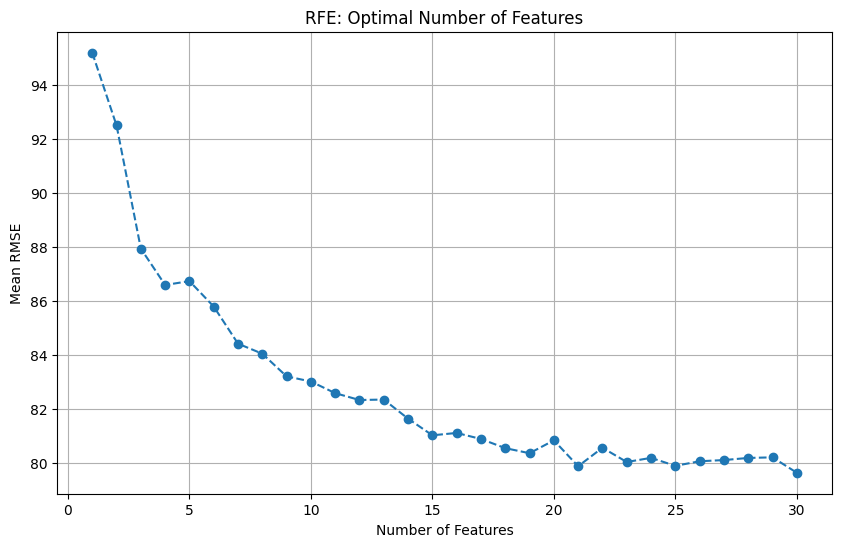

In [ ]:
# Example Usage
target_column = 'Appliances'

# Perform RFE to get feature rankings
rankings = perform_rfe(train_data, target_column)
print(rankings)

# Evaluate RMSE with different numbers of features
max_features = train_data.shape[1] - 1
feature_counts, mean_rmse = evaluate_optimal_features(train_data, target_column, max_features)

# Plot the results
plot_rfe_results(feature_counts, mean_rmse)

In [ ]:
df.drop(['rv1', 'rv2'], axis=1, inplace=True)
df.head()
df.to_csv('/content/drive/MyDrive/ML-FinalProject/final_data_no_PCA.csv', index=False)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,NSM,week_status,day_of_week
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,61200,1,0
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,61800,1,0
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,62400,1,0
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,63000,1,0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,63600,1,0
